Rafał Nowak
# Numerical Optimization, Problem set 5 (14 points)

**Submission deadline**: Thursday, 28.01.2021

* All submissions should contain single file.<br/>This can be single Jupyter notebook file (with extension `ipynb`) or ZIP archive in case the are some additional files needed.
* It is recommended to write the reports using LaTeX. 
* One can report the answers, comments and results in PDF or notebook file.
* All the source code should be written in Python or Julia.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

## Problem 5.1 (4 pts)
Complete the implementation of Newton's method (see [Boyd, *Convex Optimization*, $\S 9.5.2$])
<img src="https://i.ibb.co/RvqY16d/Boyd-Newton-method.png" alt="Boyd-Newton-method">

```python
# Remark: Implement bisection method first

###############################################################################
def newton( func, initial_x, eps=1e-5, maximum_iterations=65536, linesearch=bisection, *linesearch_args  ):
    """ 
    Newton's Method
    func:               the function to optimize It is called as "value, gradient, hessian = func( x, 2 )
    initial_x:          the starting point
    eps:                the maximum allowed error in the resulting stepsize t
    maximum_iterations: the maximum allowed number of iterations
    linesearch:         the linesearch routine
    *linesearch_args:   the extra arguments of linesearch routine
    """
    
    if eps <= 0:
        raise ValueError("Epsilon must be positive")
    x = np.asarray( initial_x.copy() )
    
    # initialization
    values = []
    runtimes = []
    xs = []
    start_time = time.time()
    iterations = 0
    
    # Newton's method updates
    while True:
        
        value, gradient, hessian = func( x , order=2 )
        value = np.double( value )
        gradient = np.matrix( gradient )
        hessian = np.matrix( hessian ) 
        
        # updating the logs
        values.append( value )
        runtimes.append( time.time() - start_time )
        xs.append( x.copy() )

        ### TODO: Compute the Newton update direction
        direction = _________

        ### TODO: Compute the Newton decrement
        newton_decrement = ________


        if __________________:   ### TODO: TERMINATION CRITERION
            break
        
        t = linesearch(func, x, direction, iterations, *linesearch_args)

        ### TODO: update x
        x = x + _____________

        iterations += 1
        if iterations >= maximum_iterations:
            raise ValueError("Too many iterations")
    
    return (x, values, runtimes, xs)
```

Test your implementation and compare the results for 
* function `my_func` from problem set 4. Remark that you should implement the case `order=2` first.
* functions `boyd_example_func` and `quadratic` from problemset 4.

You should use both `exact_line_search` and `backtracking` (from problem set 4 for `linesearch` parameter).

<img width="80%" src="https://i.ibb.co/1fQ0Nfs/Boyd-line-search.png">

In [192]:
def my_func(x, order=0):
    value = x**4 + 16*x**2 + 18*(x-4)*np.exp(x)
    if order==1:
        gradient = 4*x**3 + 32*x + 18*(x-3)*np.exp(x)
        return value, gradient
    elif order==2:
        gradient = 4*x**3 + 32*x + 18*(x-3)*np.exp(x)
        hess = 12*x**2 + 32 + 18*(x-2)*np.exp(x)
        return value, gradient, hess
    return value

In [113]:
def boyd_example_func(x, order=0):
    a = np.array([1,3])
    b = np.array([1,-3])
    c = np.array([-1,0])

    value = np.exp(a@x-0.1)+np.exp(b@x-0.1)+np.exp(c@x-0.1)
    if order==0:
        return value
    elif order==1:
        gradient = a*np.exp(a@x-0.1)+b*np.exp(b@x-0.1)+c*np.exp(c@x-0.1)
        return (value, gradient)
    elif order==2:
        gradient = a*np.exp(a@x-0.1)+b*np.exp(b@x-0.1)+c*np.exp(c@x-0.1)
        a = a.reshape(1,-1)
        b = b.reshape(1,-1)
        c = c.reshape(1,-1)
        x_ = x.reshape(-1,1)
        hessian = a.T*a*np.exp(a@x-0.1)+b.T*b*np.exp(b@x-0.1)+c.T*c*np.exp(c@x-0.1)
        return (value, gradient, hessian)
    else:
        raise ValueError("The argument \"order\" should be 0, 1 or 2")

In [5]:
def quadratic(H, b, x, order=0):
    """ 
    Quadratic Objective
    H:          the Hessian matrix
    b:          the vector of linear coefficients
    x:          the current iterate
    order:      the order of the oracle. For example, order=1 returns the value of the function and its gradient while order=2 will also return the hessian
    """
    H = np.asmatrix(H)
    b = np.asmatrix(b)
    x = np.asmatrix(x)
    
    value = float(0.5 * x @ H @ x.T + b @ x.T)

    if order == 0:
        return value
    elif order == 1:
        gradient = (np.array((H @ x.T).reshape(1,-1) + b)).reshape(-1,)
        return (value, gradient)
    elif order == 2:
        gradient = (np.array((H @ x.T).reshape(1,-1) + b)).reshape(-1,)
        hessian = H
        return (value, gradient, hessian)
    else:
        raise ValueError("The argument \"order\" should be 0, 1 or 2")

In [6]:
def bisection(f, min_, max_, eps=1e-5, max_iter=50000, debug=False):
    count = 0
    while True:
        count+=1
        
        mid_ = (min_+max_)/2
        val, grad = f(mid_, order=1)
        
        suboptimality = max(np.abs(grad), np.abs((max_-min_)/2))
        if suboptimality <= eps or count >= max_iter:
            break

        if grad > 0:
            max_ = mid_
        else:
            min_ = mid_
    if debug:
        print("Number of Iterations: ", count)
        print("Suboptimal point: ", np.round(mid_, 15))
        print("Suboptimal value: ", np.round(val, 15))
    return mid_

In [7]:
def find_initial_bracket(f, x=0, s=1e-5, k=2.0):
    a,fa = x,f(x)
    b,fb = a+s,f(a+s)
    if fb>fa:
        a,fa,b,fb,s = b,fb,a,fa,-s
    while True:
        c,fc = b+s,f(b+s)
        if fc>fb:
            return min(a,c),max(a,c)
        a,fa,b,fb,s = b,fb,c,fc,k*s

In [8]:
def exact_line_search(f, x, direction, maximum_iterations=65536, eps=1e-9, debug=False):
    
    def fun_(t, x, direction, order=0):
        val, grad = f(x+t*direction, order=1)
        if order==0:
            return val
        
        if not isinstance(grad, np.ndarray):
            return val, direction*grad
        
        direction = direction.reshape(-1,1)
        grad = grad.reshape(1,-1)
        return val, grad@direction
    
    fun = lambda t, order=0: fun_(t, x, direction, order)
    
    a,b = find_initial_bracket(fun)
    if debug:
        print(f'Initial brackets: ({a}, {b})')
    t = bisection(fun, a, b, eps, maximum_iterations, debug)
    
    return x+t*direction

In [166]:
def backtracking_line_search(f, x, direction, maximum_iterations=65536, alpha=0.4, beta=0.9, debug=False):
    t = 1
    count = 0
    act_val = f(x+t*direction)
    f_x, grad_x = f(x, order=1)
    if isinstance(grad_x, np.ndarray):
        grad_x = grad_x.reshape(-1,1)
        d = direction.reshape(1,-1)
        grad_dir = (d@grad_x)[0][0]
    else:
        grad_dir = grad_x * direction
    
    while count < maximum_iterations and act_val > f_x + t*alpha*grad_dir:
        count += 1
        t*=beta
        act_val = f(x+t*direction)
    
    if debug:
        print("Number of Iterations: ", count)
        print("t value: ", np.round(t, 15))
        print("Suboptimal point: ", np.round(x+t*direction, 15))
        print("Suboptimal value: ", np.round(act_val, 15))
    
    return x+t*direction

I've implemented the Newton method. The Hessian's inverse is calculated once and then used for direction and decrement calculations. If the decrement is small enough then calculations stop.

In [204]:
def newton(func, initial_x, eps=1e-5, maximum_iterations=65536, linesearch=bisection, *linesearch_args):
    """ 
    Newton's Method
    func:               the function to optimize It is called as "value, gradient, hessian = func( x, 2 )
    initial_x:          the starting point
    eps:                the maximum allowed error in the resulting stepsize t
    maximum_iterations: the maximum allowed number of iterations
    linesearch:         the linesearch routine
    *linesearch_args:   the extra arguments of linesearch routine
    """

    if eps <= 0:
        raise ValueError("Epsilon must be positive")
    x = np.asarray( initial_x.copy() )

    # initialization
    values = []
    runtimes = []
    xs = []
    start_time = time.time()
    iterations = 0

    # Newton's method updates
    while True:
        
        value, gradient, hessian = func( x , order=2 )
        value = np.double( value )
        gradient = np.matrix( gradient )
        hessian = np.matrix( hessian ) 

        # updating the logs
        values.append( value )
        runtimes.append( time.time() - start_time )
        xs.append( x.copy() )
        
        hessian_inv = np.linalg.inv(hessian)

        ### TODO: Compute the Newton update direction
        direction = np.array((-hessian_inv @ gradient.T).T)[0]

        ### TODO: Compute the Newton decrement
        newton_decrement = gradient @ hessian_inv @ gradient.T
        
        if newton_decrement/2 <= eps:   ### TODO: TERMINATION CRITERION
            break

        x = linesearch(func, x, direction, iterations, *linesearch_args)

        iterations += 1
        if iterations >= maximum_iterations:
            print("Too many iterations")
            break

    return (x, values, np.array(runtimes), np.array(xs))

### My function

In [201]:
res = minimize(my_func, np.array([2]), method='BFGS', jac=lambda x: my_func(x, order=1)[1])
print(res)
print('Value in optimal point: ', my_func(res['x'])[0])

      fun: -192.62418183070685
 hess_inv: array([[0.00641877]])
      jac: array([9.86250981e-07])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([2.32232459])
Value in optimal point:  -192.62418183070685


### exact line search

In [205]:
x_inf, values, runtimes, x_hist = newton(
    my_func, 
    np.array([2]), 
    eps=1e-5, 
    maximum_iterations=100,
    linesearch=exact_line_search
)

In [206]:
print('Number of Iterations:', len(x_hist))
print('Time:', np.round(runtimes[-1],3),'s')
print('Final point:', x_inf)
print('Final value:', values[-1])
print('MSE: ', np.round(np.mean((res['x'] - x_inf)**2), 15))

Number of Iterations: 2
Time: 4.006 s
Final point: [2.32232458]
Final value: -192.62418183070687
MSE:  0.0


#### backtracking line search

In [207]:
x_inf, values, runtimes, x_hist = newton(
    my_func, 
    np.array([2]), 
    eps=1e-5, 
    maximum_iterations=100,
    linesearch=backtracking_line_search
)

In [208]:
print('Number of Iterations:', len(x_hist))
print('Time:', np.round(runtimes[-1],3),'s')
print('Final point:', x_inf)
print('Final value:', values[-1])
print('MSE: ', np.round(np.mean((res['x'] - x_inf)**2), 15))

Number of Iterations: 4
Time: 0.001 s
Final point: [2.32258725]
Final value: -192.62417645203877
MSE:  6.8989565e-08


### Boyd example function

In [147]:
res = minimize(boyd_example_func, np.array([1,1]), method='BFGS', jac=lambda x: boyd_example_func(x, order=1)[1])
print(res)
print('Value in optimal point: ', boyd_example_func(res['x']))

      fun: 2.559266696658241
 hess_inv: array([[ 0.38438359, -0.00349181],
       [-0.00349181,  0.08492073]])
      jac: array([-2.33999667e-07, -5.78452418e-07])
  message: 'Optimization terminated successfully.'
     nfev: 13
      nit: 11
     njev: 13
   status: 0
  success: True
        x: array([-3.46573682e-01, -5.02272755e-08])
Value in optimal point:  2.559266696658241


#### exact line search

In [171]:
x_inf, values, runtimes, x_hist = newton(
    boyd_example_func, 
    np.array([1,1]), 
    eps=1e-5, 
    maximum_iterations=100,
    linesearch=exact_line_search
)

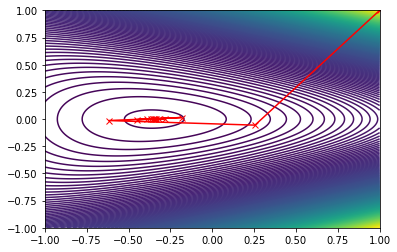

In [172]:
grid_x,grid_y = np.meshgrid(np.linspace(-1,1,200), np.linspace(-1,1,200))
points = np.array([grid_x,grid_y]).reshape(2,-1)
f_vals = boyd_example_func(points)
plt.contour(grid_x,grid_y,f_vals.reshape(grid_x.shape), 250)
plt.plot(x_hist[:,0], x_hist[:,1], 'rx-')
plt.show()

In [173]:
print('Number of Iterations:', len(x_hist))
print('Time:', np.round(runtimes[-1],3),'s')
print('Final point:', x_inf)
print('Final value:', values[-1])
print('MSE: ', np.round(np.mean((res['x'] - x_inf)**2), 15))

Number of Iterations: 13
Time: 10.541 s
Final point: [-3.49329851e-01 -1.64950618e-04]
Final value: 2.559276574251515
MSE:  3.811831006e-06


#### backtracking line search

In [167]:
x_inf, values, runtimes, x_hist = newton(
    boyd_example_func, 
    np.array([1,1]), 
    eps=1e-5, 
    maximum_iterations=100,
    linesearch=backtracking_line_search
)

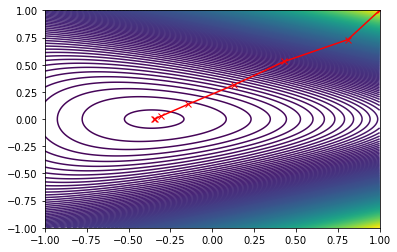

In [169]:
grid_x,grid_y = np.meshgrid(np.linspace(-1,1,200), np.linspace(-1,1,200))
points = np.array([grid_x,grid_y]).reshape(2,-1)
f_vals = boyd_example_func(points)
plt.contour(grid_x,grid_y,f_vals.reshape(grid_x.shape), 250)
plt.plot(x_hist[:,0], x_hist[:,1], 'rx-')
plt.show()

In [170]:
print('Number of Iterations:', len(x_hist))
print('Time:', np.round(runtimes[-1],3),'s')
print('Final point:', x_inf)
print('Final value:', values[-1])
print('MSE: ', np.round(np.mean((res['x'] - x_inf)**2), 15))

Number of Iterations: 8
Time: 0.004 s
Final point: [-3.46570386e-01  2.12417725e-06]
Final value: 2.559266696697338
MSE:  7.796e-12


### Quadratic function

In [175]:
H = np.diag([1., 2., 3.])
b = np.array([1., 1., 1.])
quadratic_ = lambda x, order=0: quadratic(H, b, x, order)
res = minimize(quadratic_, np.array([1., 1., 1.]), method='BFGS', jac=lambda x: quadratic_(x, order=1)[1])
print(res)
print('Value in optimal point: ', quadratic_(res['x']))

      fun: -0.9166666666662825
 hess_inv: array([[ 1.01300345, -0.01318065, -0.00608001],
       [-0.01318065,  0.51350724,  0.00728037],
       [-0.00608001,  0.00728037,  0.34467277]])
      jac: array([-1.29275435e-07,  3.71691441e-07,  1.43149579e-06])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([-1.00000013, -0.49999981, -0.33333286])
Value in optimal point:  -0.9166666666662825


#### exact line search

In [177]:
x_inf, values, runtimes, x_hist = newton(
    quadratic_, 
    np.array([1., 1., 1.]), 
    eps=1e-5, 
    maximum_iterations=100,
    linesearch=exact_line_search
)

In [178]:
print('Number of Iterations:', len(x_hist))
print('Time:', np.round(runtimes[-1],3),'s')
print('Final point:', x_inf)
print('Final value:', values[-1])
print('MSE: ', np.round(np.mean((res['x'] - x_inf)**2), 15))

Number of Iterations: 2
Time: 8.8 s
Final point: [-1.         -0.5        -0.33333333]
Final value: -0.9166666666666666
MSE:  9.3e-14


#### backtracking line search

In [179]:
x_inf, values, runtimes, x_hist = newton(
    quadratic_, 
    np.array([1., 1., 1.]), 
    eps=1e-5, 
    maximum_iterations=100,
    linesearch=backtracking_line_search
)

In [180]:
print('Number of Iterations:', len(x_hist))
print('Time:', np.round(runtimes[-1],3),'s')
print('Final point:', x_inf)
print('Final value:', values[-1])
print('MSE: ', np.round(np.mean((res['x'] - x_inf)**2), 15))

Number of Iterations: 2
Time: 0.001 s
Final point: [-1.         -0.5        -0.33333333]
Final value: -0.9166666666666666
MSE:  9.3e-14


### Quadratic function

In [181]:
d = 10
while True:
    H = np.random.randint(0,100*d**2,(d,d))
    H = (H+H.T)/2
    w,v = np.linalg.eig(H)
    H = v @ np.diag(np.abs(w)) @ np.linalg.inv(v)
    w,v = np.linalg.eig(H)
    if np.all(w>0):
        break
        
b = np.random.randint(0,100*d,(d,))
x0 = np.ones(d)

In [182]:
quadratic_ = lambda x, order=0: quadratic(H, b, x, order)
res = minimize(quadratic_, x0, method='BFGS', jac=lambda x: quadratic_(x, order=1)[1])
print(res)
print('Value in optimal point: ', quadratic_(res['x']))

      fun: -120.72528082334834
 hess_inv: array([[ 4.15033672e-04, -2.01972036e-04, -1.31047048e-04,
         2.11928966e-04, -1.54532775e-04, -7.46294453e-05,
         1.82747814e-04,  1.10394189e-04, -1.00887934e-04,
        -1.20334198e-04],
       [-2.01972036e-04,  4.92672639e-04, -2.25993432e-04,
        -2.69294496e-04,  5.64097109e-05, -7.26704383e-05,
        -9.97595973e-06,  2.30116412e-04,  1.04576265e-04,
        -5.71732029e-05],
       [-1.31047048e-04, -2.25993432e-04,  5.37288047e-04,
         1.75274231e-04, -3.68979711e-05,  8.92554372e-05,
        -2.19052677e-04, -3.86766320e-04, -1.09386971e-04,
         1.56665468e-04],
       [ 2.11928966e-04, -2.69294496e-04,  1.75274231e-04,
         5.69770465e-04, -2.86499693e-04, -2.23464490e-05,
         4.17754962e-05, -1.86695480e-04, -2.86926267e-04,
         9.25429663e-05],
       [-1.54532775e-04,  5.64097109e-05, -3.68979711e-05,
        -2.86499693e-04,  3.71466046e-04,  4.02632314e-05,
        -1.67548587e-04,  3.

#### exact line search

In [185]:
x_inf, values, runtimes, x_hist = newton(
    quadratic_, 
    x0, 
    eps=1e-5, 
    maximum_iterations=100,
    linesearch=exact_line_search
)

In [186]:
print('Number of Iterations:', len(x_hist))
print('Time:', np.round(runtimes[-1],3),'s')
print('Final point:', x_inf)
print('Final value:', values[-1])
print('MSE: ', np.round(np.mean((res['x'] - x_inf)**2), 15))

Number of Iterations: 2
Time: 13.07 s
Final point: [-0.13115794  0.22815991 -0.04693199 -0.03781513 -0.04923107 -0.10200059
  0.00981336  0.05057865 -0.02534398 -0.00367327]
Final value: -120.72528082334833
MSE:  0.0


#### backtracking line search

In [183]:
x_inf, values, runtimes, x_hist = newton(
    quadratic_, 
    x0, 
    eps=1e-5, 
    maximum_iterations=100,
    linesearch=backtracking_line_search
)

In [184]:
print('Number of Iterations:', len(x_hist))
print('Time:', np.round(runtimes[-1],3),'s')
print('Final point:', x_inf)
print('Final value:', values[-1])
print('MSE: ', np.round(np.mean((res['x'] - x_inf)**2), 15))

Number of Iterations: 2
Time: 0.003 s
Final point: [-0.13115794  0.22815991 -0.04693199 -0.03781513 -0.04923107 -0.10200059
  0.00981336  0.05057865 -0.02534398 -0.00367327]
Final value: -120.72528082334833
MSE:  0.0


Every function was tested with both line search methods. In every case, the backtracking search was much faster than the exact line search. What surprised me is the fact, that the exact line search was less accurate than the backtracking search for the Boyd example function.

---

## Problem 5.2 (6 pts)

Complete the implementation of Conjugate gradients method (see [Nocedal, Wright, *Numerical Optimization*, $\S 5.2$])

<img src="https://i.ibb.co/Hxn9PmM/Nocedal-Wright-CG-FR.png">

```python

###############################################################################
def cg( func, initial_x, eps=1e-5, maximum_iterations=65536, linesearch=bisection, *linesearch_args  ):
    """ 
    Conjugate Gradient
    func:               the function to optimize It is called as "value, gradient = func( x, 1 )
    initial_x:          the starting point
    eps:                the maximum allowed error in the resulting stepsize t
    maximum_iterations: the maximum allowed number of iterations
    linesearch:         the linesearch routine
    *linesearch_args:   the extra arguments of linesearch routine
    """
    
    if eps <= 0:
        raise ValueError("Epsilon must be positive")
    x = np.asarray( initial_x.copy() )
    
    # initialization
    values = []
    runtimes = []
    xs = []
    start_time = time.time()
    m = len( initial_x )
    iterations = 0
    direction = np.asmatrix( np.zeros( initial_x.shape ) )
    
    # conjugate gradient updates
    while True:
        
        value, gradient = func( x , 1 )
        value = np.double( value )
        gradient = np.asarray( gradient )
        
        # updating the logs
        values.append( value )
        runtimes.append( time.time() - start_time )
        xs.append( x.copy() )

        # if ( TODO: TERMINATION CRITERION ): break
        
        # beta = TODO: UPDATE BETA
        
        # reset after #(dimensions) iterations
        if iterations % m == 0:
            beta = 0
        
        # direction = TODO: FLETCHER-REEVES CONJUGATE GRADIENT UPDATE
        
        t = linesearch(func, x, direction, iterations, *linesearch_args)
        
        x += t * direction

        iterations += 1
        if iterations >= maximum_iterations:
            raise ValueError("Too many iterations")
    
    return (x, values, runtimes, xs)
```

Next, copy the function above but use the following Polak-Riberie formulae:
$$ \beta_{k+1}^{\mathtt{PR}} = \frac{\nabla f_{k+1}^T(\nabla f_{k+1} - \nabla f_k)}{\|f_k\|^2}$$

Observe that we applied the reset trick in lines 44-45.
It is worth reading more implementation hints in section [Nocedal, Wright, *Numerical Optimization*, $\S 5.2$].


Compare the efficiency (number of function/gradient evaluations) of FR and PR updates in CG method for Powell's optimization problem (PSF):
$$ \min_{-10 \leq x_i \leq 10} (x_1+10x_2)^2+5(x_3-x_4)^2+(x_2-2x_3)^4 + 10(x_1-x_4)^4,$$


Observe that $f(X^*)=0$ for $X^*=0$.

More info about PSF can be found, for example, here http://www.optimization-online.org/DB_FILE/2012/03/3382.pdf.

Compare your results with [Nocedal, Wright, *Numerical Optimization*, Table 5.1] (row XPOWELL)
<img width=50% src="https://i.ibb.co/6PVGJrS/Table51.png">

---

## Problem 5.3 (2 pts)
Show experimentally that affine invariance of Newton's method. 

Let $f:\mathbb{R}^n\to\mathbb{R}$ be a convex function.
Consider an affine transform $y\mapsto Ay + b$, where $A \in \mathbb{R}^{n\times n}$ is invertible and
$b \in \mathbb R^n$.

Define the function $g : \mathbb R^n \mapsto \mathbb{R}$ by $g(y) = f(Ay + b)$.
Denote by $x^{(k)}$ the k-th iterate of Newton’s method performed on $f$.
Denote by $y^{(k)}$ the k-th iterate of Newton’s method performed on $g$.
* Show that if $x^{(k)} = Ay^{(k)} + b$, then $x^{(k+1)} = Ay^{(k+1)} + b$.
* Show that Newton's decrement does not depend on the coordinates, i.e., show that $λ(x^{(k)}) = λ(y^{(k)} ).$

Together, this implies that Newton’s method is affine invariant. As an important consequence,
Newton’s method cannot be improved by a change of coordinates, unlike gradient descent.

---

## Problem 5.4 (2 pts)
Show experimentally that conjugate gradient method is *not* affine invariant.


For example consider the quadratic (convex) function $f:\mathbb R^n \to \mathbb R$ as follows
$$ f(x) = \frac12 x^T H x - c^T x,$$
where $H$ positive semi-definite.

Consider an affine transformation $y\mapsto Ay$, where  $A \in \mathbb{R}^{n\times n}$ is invertible:
* Denote by $x^{(0)} , x^{(1)} , x^{(2)}$ the first three iterates of conjugate gradient descent on $f(x)$ initialized at $x^{(0)}$.
* Now, let $y^{(0)}$ be the point such that $x^{(0)} = Ay^{(0)}$. Denote by $y^{(0)} , y^{(1)} , y^{(2)}$ the first three iterates of conjugate gradient descent on $g(y) = f(Ay)$ initialized at $y^{(0)}$.
* Provide an explicit example of $H, A$ and $x^{(0)}$ such that $x^{(1)} \neq Ay^{(1)}$ and $x^{(2)} \neq Ay^{(2)}$.